In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pysyncon import Dataprep, Synth, AugSynth

In [2]:
# All states:
states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
# States belonging to RGGI. Exclude VA here; it was only in RGGI for a short time
# Connecticut, Delaware, Maine, Maryland, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Rhode Island, and Vermont 
rggi_states = ["CT", "DE", "ME", "MD", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
# States with cap-and-trade programs as well as AK and HI, which are of course outside the continental US.
other_states = ["CA", "AK", "HI"]
# States not belonging to RGGI or other cap-and-trade programs.
# WA will be included here because its cap-and-trade program was not around until after 2020.
control_states = list(set(states) - set(rggi_states) - set(other_states))

# Verify all fifty states accounted for:
assert(len(rggi_states) + len(control_states) + len(other_states) == 50)

In [3]:
# Read in the dataframe
df = pd.read_csv(os.path.join("..", "..", "..", "SharedData", "total_state_data.csv"))
df.date = pd.to_datetime(df.date)
df = df[(df.date.dt.year>=1990)&(df.date.dt.year<2020)]
df.columns

Index(['state', 'state_sq_ft', 'year', 'month', 'date', 'monthly_population',
       'yearly_population', 'monthly_pop_density', 'yearly_pop_density',
       'monthly_emissions', 'monthly_emissions_sma', 'prcp', 'snow', 'tavg',
       'gdp_rel_2017', 'gdp_rel_2017_interp', 'yearly_gdp_rel_2017',
       'monthly_energy_prod', 'yearly_energy_prod', 'monthly_energy_use',
       'yearly_energy_use', 'monthly_energy_flow', 'yearly_energy_flow',
       'monthly_num_plants', 'yearly_num_plants', 'monthly_energy_total',
       'yearly_energy_total', 'monthly_energy_renew', 'yearly_energy_renew',
       'monthly_renew_pct', 'yearly_renew_pct', 'monthly_energy_fossil',
       'yearly_energy_fossil', 'monthly_fossil_pct', 'yearly_fossil_pct'],
      dtype='object')

In [4]:
# Do some per capita calculations:
df['co2_per_capita']   = df['monthly_emissions']   / df['monthly_population']
df['gdp_per_capita']   = df['gdp_rel_2017_interp'] / df['monthly_population']
df['eprod_per_capita'] = df['monthly_energy_prod'] / df['monthly_population']
df['eflow_per_capita'] = df['monthly_energy_flow'] / df['monthly_population']

df['monthly_fossil_pct'].sample(5)

11450    0.767349
13581    0.842156
14437    0.718377
11033    0.977661
4165     0.951781
Name: monthly_fossil_pct, dtype: float64

In [5]:
# Set up our state lists
state_id = "DE"
control_ids = list(set(control_states) - set([state_id]))
rggi_ids = list(set(rggi_states) - set([state_id]))

# Stop the notebook if something goes wrong
assert(state_id not in other_states)
assert(len(control_ids) + len(rggi_ids) + 1 == 50 - len(other_states))

# Do computations monthly
month_jumps = 3

# Set up ranges
UL = 2009
LL_TIME = 1997      # Time range over which to perform fit
LL_FEATURE = 1997   # Time range over which to perform predictor operations
# Special predictor ranges
LL_WEATHER = 1997 # was 1990
LL_GDP = 1997
LL_POPULATION = 1997 # was 1990

preintervention_time_range = df.date[(df.date.dt.year>=LL_TIME)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]

preintervention_feature_range = df.date[(df.date.dt.year>=LL_FEATURE)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]
preintervention_weather_range = df.date[(df.date.dt.year>=LL_WEATHER)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]
preintervention_gdp_range = df.date[(df.date.dt.year>=LL_GDP)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]
preintervention_per_capita_range = df.date[(df.date.dt.year>=LL_POPULATION)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]

years = pd.date_range(start='1997-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]

In [6]:
special_predictors = [
    ('tavg', preintervention_weather_range, "var"),
    #('prcp', preintervention_weather_range, "mean"),
    ('eprod_per_capita', preintervention_per_capita_range, "mean"),
    ('eflow_per_capita', preintervention_per_capita_range, "mean"),
    ('gdp_per_capita', preintervention_gdp_range, "mean"),
    ('monthly_fossil_pct', preintervention_per_capita_range, "mean")
    ]

special_predictors2=[
        ('eprod_per_capita', preintervention_per_capita_range, "mean"),
        ('eflow_per_capita', preintervention_per_capita_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('yearly_pop_density', preintervention_per_capita_range, "mean"),
        # ('co2_per_capita', [1990], "mean"),
        # ('co2_per_capita', [2000], "mean"),
        ('yearly_renew_pct', preintervention_per_capita_range, "mean"),
        ('yearly_fossil_pct', preintervention_per_capita_range, "mean")
        ]

In [7]:
dataprep_control = Dataprep(
    foo=df,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=special_predictors,
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state_id,
    controls_identifier= control_ids,
    time_optimize_ssr=preintervention_time_range
)
print(dataprep_control)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: KY, KS, NC, IN, WV, OK, WA, IA, MT, VA, MS, ND, MI, IL, TN, MN, TX, GA, AL, WY, MO, ID, LA, FL, NM, SD, NE, AR, NV, SC, UT, WI, OR, OH, AZ, CO
Time range in data: 1990-01-01 00:00:00 - 2019-12-01 00:00:00
Time range for loss minimization: 4200    1997-01-01
4203    1997-04-01
4206    1997-07-01
4209    1997-10-01
4788    1998-01-01
4791    1998-04-01
4794    1998-07-01
4797    1998-10-01
5376    1999-01-01
5379    1999-04-01
5382    1999-07-01
5385    1999-10-01
5964    2000-01-01
5967    2000-04-01
5970    2000-07-01
5973    2000-10-01
6552    2001-01-01
6555    2001-04-01
6558    2001-07-01
6561    2001-10-01
7140    2002-01-01
7143    2002-04-01
7146    2002-07-01
7149    2002-10-01
7728    2003-01-01
7731    2003-04-01
7734    2003-07-01
7737    2003-10-01
8316    2004-01-01
8319    2004-04-01
8322    2004-07-01
8325    2004-10-01
8904    2005-01-01
8907    2005-04-01
8910    2005-07-01
8913    2005-10-01
9

In [8]:
dataprep_rggi = Dataprep(
    foo=df,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=special_predictors,
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state_id,
    controls_identifier= rggi_ids,
    time_optimize_ssr=preintervention_time_range
)
print(dataprep_rggi)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: NJ, MA, NH, VT, RI, CT, ME, NY, MD, PA
Time range in data: 1990-01-01 00:00:00 - 2019-12-01 00:00:00
Time range for loss minimization: 4200    1997-01-01
4203    1997-04-01
4206    1997-07-01
4209    1997-10-01
4788    1998-01-01
4791    1998-04-01
4794    1998-07-01
4797    1998-10-01
5376    1999-01-01
5379    1999-04-01
5382    1999-07-01
5385    1999-10-01
5964    2000-01-01
5967    2000-04-01
5970    2000-07-01
5973    2000-10-01
6552    2001-01-01
6555    2001-04-01
6558    2001-07-01
6561    2001-10-01
7140    2002-01-01
7143    2002-04-01
7146    2002-07-01
7149    2002-10-01
7728    2003-01-01
7731    2003-04-01
7734    2003-07-01
7737    2003-10-01
8316    2004-01-01
8319    2004-04-01
8322    2004-07-01
8325    2004-10-01
8904    2005-01-01
8907    2005-04-01
8910    2005-07-01
8913    2005-10-01
9492    2006-01-01
9495    2006-04-01
9498    2006-07-01
9501    2006-10-01
10080   2007-01-01
10083   20

In [9]:
# Do a synthetic control fit to the data using control states
synth = Synth()
#synth.fit(dataprep=dataprep_control, optim_method='BFGS')
synth.fit(dataprep=dataprep_control)
print(synth.weights(threshold=.001))

FL    0.135
NV    0.140
CO    0.725
Name: weights, dtype: float64


c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


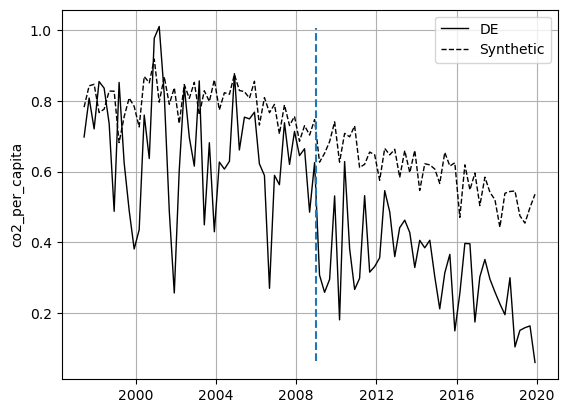

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


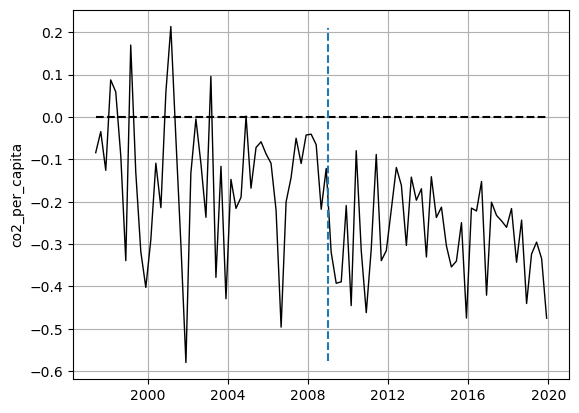

0.04045443996816315
-3.0656273975481403
0.04045443996816315


In [11]:
synth.path_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
synth.gaps_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
print(synth.loss_V)
print(synth.loss_W)
synth.summary()

print(synth.loss_V)

In [82]:
# Do a synthetic control fit to the data using control states
aug = AugSynth()
#synth.fit(dataprep=dataprep_control, optim_method='BFGS')
aug.fit(dataprep=dataprep_control)
print(aug.weights(threshold=.001))

NV    0.003
SC    0.106
SD    0.029
NC    0.350
MN    0.002
KS    0.101
KY    0.002
LA    0.001
WY    0.003
IL    0.002
CO    0.002
VA    0.407
WV    0.003
Name: weights, dtype: float64


c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


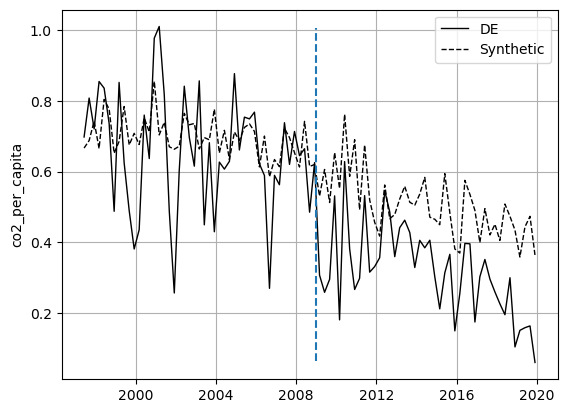

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


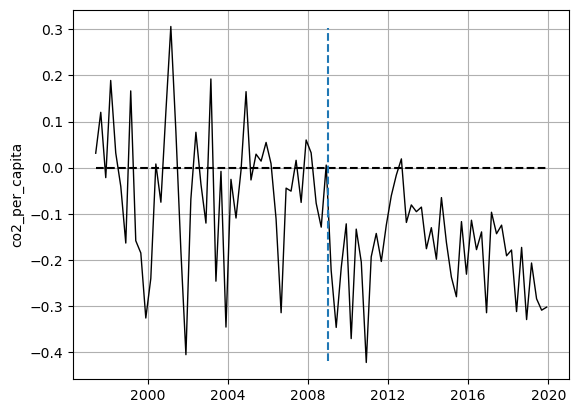

0.01842398853174445


,treated,synthetic,sample mean
special.1.tavg,215.379,212.285,257.018
special.2.eprod_per_capita,0.000,0.016,0.065
special.3.eflow_per_capita,-0.029,-0.012,0.033
special.4.gdp_per_capita,0.006,0.004,0.004
special.5.monthly_fossil_pct,0.955,0.614,0.719


In [87]:
aug.path_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
aug.gaps_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
print(aug.mspe())
aug.summary()